In [62]:
import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display
import os
import matplotlib.pyplot as plt
from itertools import product

from py_files.healper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)

DATA_PATH = "data/play_by_play/"

# load ALL of the data and clean it

In [73]:
rel_cols = [
    'event_type', 'game_seconds_remaining', 'event_team_type',
    'home_final', 'game_id', 'home_final', 
    'away_final', 'home_name', 'away_name']
dataframes = []
for file in sorted(list(os.listdir(DATA_PATH))):
    print(file)
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')
        df = df[rel_cols]
        dataframes.append(df)
        
df_orig = pd.concat(dataframes)
display(df_orig.head(10))

play_by_play_2010_11.csv
play_by_play_2011_12.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2012_13.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2013_14.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (47,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2014_15.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2015_16.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49,55,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2016_17.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2017_18.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (47,54,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2018_19.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2019_20.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2020_21.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2021_22.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2022_23.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (48,49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2023_24.csv


/tmp/ipykernel_47145/1998303178.py:9: DtypeWarning: Columns (42,43,49,50,120,136) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


,event_type,game_seconds_remaining,event_team_type,home_final,game_id,home_final,away_final,home_name,away_name
0,GAME_SCHEDULED,3600,NaN,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
1,CHANGE,3600,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
2,CHANGE,3600,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
3,FACEOFF,3600,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
4,HIT,3585,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
5,CHANGE,3572,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
6,CHANGE,3568,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
7,CHANGE,3565,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
8,CHANGE,3557,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
9,HIT,3554,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens


In [76]:
df = df_orig.copy()

# select only the relevant columns
rel_cols = [
    'event_type', 'game_seconds_remaining', 'event_team_type',
    'home_final', 'game_id', 'home_final', 
    'away_final', 'home_name', 'away_name']
df = df[rel_cols]

# clean the data
df = df.dropna(subset=['event_team_type'])
df = df[~df['event_type'].isin(['CHANGE', 'DELAYED_PENALTY', 'CHALLENGE', 'FAILED_SHOT_ATTEMPT', 'UNKNOWN'])]

In [78]:
# consolidate the overall dataframe into a dataframe with just events
df_events = df[['game_id', 'event_type', 'game_seconds_remaining', 'event_team_type']].copy()
df_events['event'] = df_events['event_type'].astype(str) + '_' + df_events['event_team_type'].astype(str).str.upper()
df_events = df_events.sort_values(by=['game_id', 'game_seconds_remaining'], ascending=[True, False])
df_events = df_events[['game_id', 'event', 'game_seconds_remaining']]

first_rows = df_events['game_id'] != df_events['game_id'].shift(1)
df_events['seconds_diff'] = np.abs(df_events['game_seconds_remaining'].diff().fillna(0))
df_events.loc[first_rows, 'seconds_diff'] = 0

# compute the probability tables for the MC

In [82]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)
third_rows = (df_mc['game_id'] != df_mc['game_id'].shift(3)) & (~first_rows) & (~second_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc['prev3'] = df_mc['event'].shift(3)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"
df_mc.loc[first_rows | second_rows | third_rows, 'prev3'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev3'] + ',' + df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities3 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities3['join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities3 = probabilities3.merge(given_counts, on='prev_events', how='left')
probabilities3 = probabilities3.merge(join_counts, on='join', how='left')
probabilities3 = probabilities3.fillna(0)
probabilities3['probability'] = probabilities3['join_count'] / probabilities3['given_count']
probabilities3 = probabilities3.sort_values(by='probability', ascending=False)
probabilities3 = probabilities3[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities3)

,prev_events,curr_event,probability,given_count,join_count
77262,"PENALTY_HOME,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY",MISSED_SHOT_AWAY,1.0000000,1,1.0000000
78525,"TAKEAWAY_HOME,PENALTY_AWAY,MISSED_SHOT_HOME",FACEOFF_HOME,1.0000000,1,1.0000000
69750,"PENALTY_HOME,SHOT_AWAY,GOAL_AWAY",FACEOFF_AWAY,1.0000000,1,1.0000000
74079,"PENALTY_HOME,MISSED_SHOT_AWAY,SHOT_AWAY",FACEOFF_HOME,1.0000000,2,2.0000000
74057,"FACEOFF_HOME,PENALTY_HOME,MISSED_SHOT_AWAY",SHOT_AWAY,1.0000000,1,1.0000000
...,...,...,...,...,...
35659,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",HIT_HOME,0.0000000,214,0.0000000
35660,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",HIT_AWAY,0.0000000,214,0.0000000
35661,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",GIVEAWAY_HOME,0.0000000,214,0.0000000
35662,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",BLOCKED_SHOT_AWAY,0.0000000,214,0.0000000


In [83]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities2 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities2['join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities2 = probabilities2.merge(given_counts, on='prev_events', how='left')
probabilities2 = probabilities2.merge(join_counts, on='join', how='left')
probabilities2 = probabilities2.fillna(0)
probabilities2['probability'] = probabilities2['join_count'] / probabilities2['given_count']
probabilities2 = probabilities2.sort_values(by='probability', ascending=False)
probabilities2 = probabilities2[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities2)

,prev_events,curr_event,probability,given_count,join_count
5364,"PENALTY_AWAY,GIVEAWAY_AWAY",FACEOFF_AWAY,1.0000000,1,1.0000000
5697,"#,SHOT_AWAY",FACEOFF_HOME,1.0000000,1,1.0000000
5901,"#,GOAL_HOME",GOAL_AWAY,1.0000000,1,1.0000000
5875,"PENALTY_HOME,TAKEAWAY_AWAY",GIVEAWAY_AWAY,1.0000000,1,1.0000000
5850,"#,HIT_HOME",FACEOFF_AWAY,1.0000000,1,1.0000000
...,...,...,...,...,...
4963,"GOAL_HOME,PENALTY_HOME",MISSED_SHOT_HOME,0.0000000,74,0.0000000
4962,"GOAL_HOME,PENALTY_HOME",TAKEAWAY_HOME,0.0000000,74,0.0000000
4961,"GOAL_HOME,PENALTY_HOME",GOAL_HOME,0.0000000,74,0.0000000
4960,"GOAL_HOME,PENALTY_HOME",SHOT_HOME,0.0000000,74,0.0000000


In [84]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc.loc[first_rows, 'prev1'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities1 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities1['join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities1 = probabilities1.merge(given_counts, on='prev_events', how='left')
probabilities1 = probabilities1.merge(join_counts, on='join', how='left')
probabilities1 = probabilities1.fillna(0)
probabilities1['probability'] = probabilities1['join_count'] / probabilities1['given_count']
probabilities1 = probabilities1.sort_values(by='probability', ascending=False)
probabilities1 = probabilities1[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities1)

,prev_events,curr_event,probability,given_count,join_count
9,#,FACEOFF_HOME,0.5065710,17425,8827.0000000
0,#,FACEOFF_AWAY,0.4921090,17425,8575.0000000
225,GOAL_HOME,FACEOFF_HOME,0.4900366,52392,25674.0000000
297,GOAL_AWAY,FACEOFF_HOME,0.4766061,48004,22879.0000000
288,GOAL_AWAY,FACEOFF_AWAY,0.4762520,48004,22862.0000000
...,...,...,...,...,...
13,#,MISSED_SHOT_HOME,0.0000000,17425,0.0000000
7,#,GIVEAWAY_AWAY,0.0000000,17425,0.0000000
320,PENALTY_AWAY,TAKEAWAY_AWAY,0.0000000,71748,0.0000000
326,PENALTY_HOME,HIT_AWAY,0.0000000,67085,0.0000000


In [85]:
probabilities1.to_csv('data/probabilities1.csv', index=False)
probabilities2.to_csv('data/probabilities2.csv', index=False)
probabilities3.to_csv('data/probabilities3.csv', index=False)

In [105]:
# create a probabilities dataframe with all of the possible 3-state + curr combinations
start_states = [('#', '#', '#')]
start_states += list(product(['#'], ['#'], curr_events))
start_states += list(product(['#'], curr_events, curr_events))
start_states += list(product(curr_events, curr_events, curr_events))

all_states = list(product(start_states, curr_events))
all_states = [a + (b, ) for a, b in all_states]

probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['1event'] = probabilities_avg['prev1']

probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
probabilities_avg = probabilities_avg.fillna(0)
probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
rel_cols = [
    'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
    'probability_1', 'probability_2', 'probability_3',
    'given_count_1', 'given_count_2', 'given_count_3',
    'join_count_1',  'join_count_2', 'join_count_3']
probabilities_avg = probabilities_avg[rel_cols]

display(probabilities_avg)


,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921090,0.4921090,0.4921090,0.4921090,17425,17425.0000000,17425.0000000,8575.0000000,8575.0000000,8575.0000000
1,#,#,#,HIT_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,HIT_AWAY,0.0003443,0.0003443,0.0003443,0.0003443,17425,17425.0000000,17425.0000000,6.0000000,6.0000000,6.0000000
3,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111145,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,MISSED_SHOT_HOME,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111146,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,TAKEAWAY_AWAY,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111147,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,GOAL_AWAY,0.0000099,0.0000298,0.0000000,0.0000000,67085,2779.0000000,515.0000000,2.0000000,0.0000000,0.0000000
111148,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,PENALTY_AWAY,0.2654426,0.1176120,0.3544440,0.3242718,67085,2779.0000000,515.0000000,7890.0000000,985.0000000,167.0000000


In [106]:
probabilities_avg.to_csv('data/probabilities_avg.csv', index=False)

# analysis / display stuff

Number of events per type over 10 years
event_type
FACEOFF         1026697
SHOT             973956
HIT              814129
BLOCKED_SHOT     504538
MISSED_SHOT      416377
GIVEAWAY         305876
TAKEAWAY         242649
PENALTY          139288
GOAL             102805
Name: count, dtype: int64
Events per game


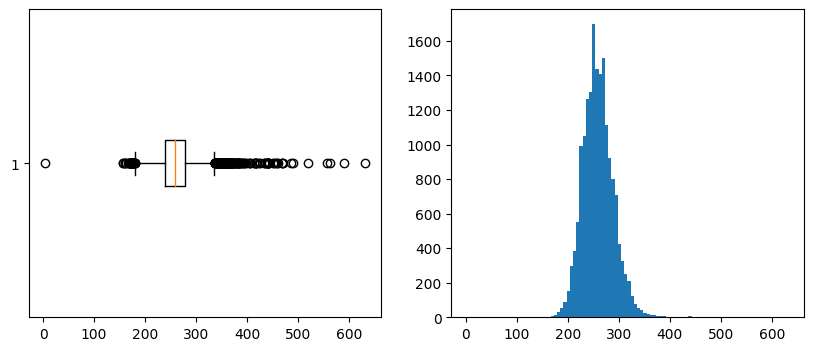

In [115]:
# show the number of times each event occurs
print("Number of events per type over 10 years")
print(df['event_type'].value_counts())

# show the distribution of events per game
events_per_game = df.groupby('game_id').count()['event_type']
print("Events per game")
plt.subplot(1,2,1)
plt.boxplot(events_per_game, vert=False)
plt.subplot(1,2,2)
plt.hist(events_per_game, bins=100)
plt.gcf().set_size_inches(10, 4)
plt.show()

In [104]:
# print a correlation matrix between the columns probability_1, probability_2, probability_3
corr = probabilities_avg[['probability_1', 'probability_2', 'probability_3']].corr()
display(corr)

,probability_1,probability_2,probability_3
probability_1,1.0000000,0.7953449,0.5956938
probability_2,0.7953449,1.0000000,0.5951818
probability_3,0.5956938,0.5951818,1.0000000


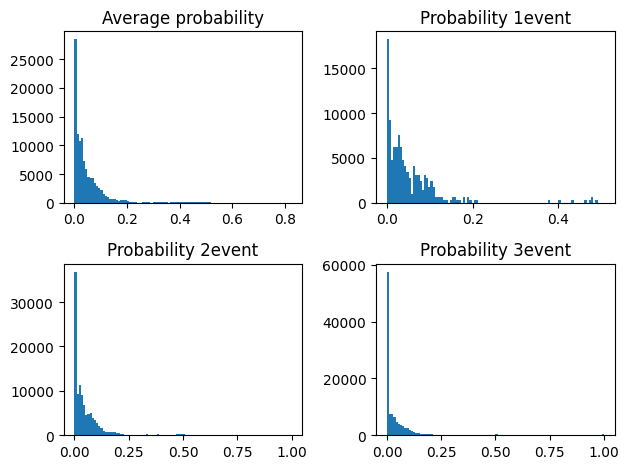

In [120]:

plt.subplot(2, 2, 1)
plt.hist(probabilities_avg['probability_avg'], label="avg", bins=100)
plt.title("Average probability")

plt.subplot(2, 2, 2)
plt.hist(probabilities_avg['probability_1'], label="1event", bins=100)
plt.title("Probability 1event")

plt.subplot(2, 2, 3)
plt.hist(probabilities_avg['probability_2'], label="2event", bins=100)
plt.title("Probability 2event")

plt.subplot(2, 2, 4)
plt.hist(probabilities_avg['probability_3'], label="3event", bins=100)
plt.title("Probability 3event")

plt.tight_layout()
plt.show()


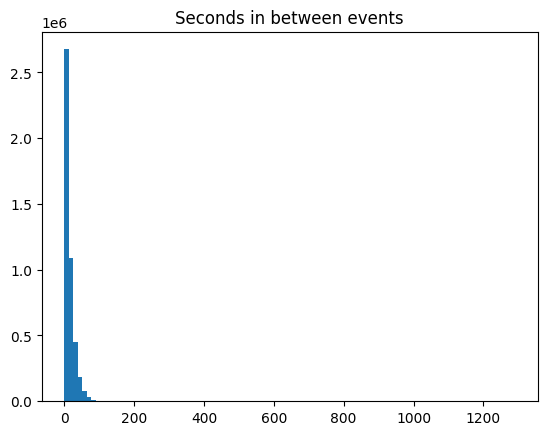

In [121]:
plt.title("Seconds in between events")
plt.hist(df_events['seconds_diff'], bins=100)
plt.show()